In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 140)
DATA_PATH = None

In [2]:
if DATA_PATH is not None and Path(DATA_PATH).exists():
    p = Path(DATA_PATH)
    if p.suffix.lower() in {'.xlsx', '.xls'}:
        import openpyxl
        df = pd.read_excel(p)
    else:
        df = pd.read_csv(p)
    data_source = "external"
else:
    rng = np.random.default_rng(42)
    n = 1000
    date = pd.date_range('2023-01-01', periods=n, freq='D')
    category = rng.choice(['A','B','C','D'], size=n, p=[0.4,0.3,0.2,0.1])
    price = np.abs(rng.normal(100, 20, n)).round(2)
    volume = rng.lognormal(mean=10, sigma=0.5, size=n).astype(int)
    returns = rng.normal(0.001, 0.02, n)
    df = pd.DataFrame({'date':date,'category':category,'price':price,'volume':volume,'returns':returns})
    idx = rng.choice(df.index, size=int(0.03*n), replace=False)
    df.loc[idx, 'price'] = np.nan
    out = Path('data/synthetic_feature_eng.csv')
    out.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(out, index=False)
    data_source = f"synthetic->{out.as_posix()}"
df.head(3)

,date,category,price,volume,returns
0,2023-01-01,C,85.16,21071,-0.012632
1,2023-01-02,B,118.49,17761,0.041628
2,2023-01-03,C,100.69,32802,0.000351


In [3]:
if 'price' in df.columns:
    df['log_price'] = np.log1p(df['price'])

In [4]:
if 'returns' not in df.columns and 'price' in df.columns:
    if 'date' in df.columns:
        tmp = df[['date','price']].sort_values('date')
        tmp['returns'] = tmp['price'].pct_change()
        df = df.merge(tmp[['date','returns']], on='date', how='left')
    else:
        df = df.sort_index()
        df['returns'] = df['price'].pct_change()
if 'returns' in df.columns:
    if 'date' in df.columns:
        df = df.sort_values('date')
    df['rolling_return_mean_5'] = df['returns'].rolling(5, min_periods=1).mean()

In [5]:
if 'category' in df.columns:
    dummies = pd.get_dummies(df['category'], prefix='cat')
    df = pd.concat([df, dummies], axis=1)
df.head()

,date,category,price,volume,returns,log_price,rolling_return_mean_5,cat_A,cat_B,cat_C,cat_D
0,2023-01-01,C,85.16,21071,-0.012632,4.456206,-0.012632,False,False,True,False
1,2023-01-02,B,118.49,17761,0.041628,4.783233,0.014498,False,True,False,False
2,2023-01-03,C,100.69,32802,0.000351,4.621929,0.009782,False,False,True,False
3,2023-01-04,B,94.34,19576,0.021561,4.557449,0.012727,False,True,False,False
4,2023-01-05,A,97.88,18894,-0.000066,4.593907,0.010168,True,False,False,False


In [6]:
num_df = df.select_dtypes(include=[np.number])
if 'target' in num_df.columns:
    corr = num_df.corr(numeric_only=True)['target'].sort_values(ascending=False)
else:
    corr = num_df.corr(numeric_only=True).stack().dropna().sort_values(ascending=False).head(10)
corr

price                  price                    1.000000
volume                 volume                   1.000000
rolling_return_mean_5  rolling_return_mean_5    1.000000
log_price              log_price                1.000000
returns                returns                  1.000000
log_price              price                    0.987946
price                  log_price                0.987946
rolling_return_mean_5  returns                  0.450038
returns                rolling_return_mean_5    0.450038
rolling_return_mean_5  volume                   0.033549
dtype: float64

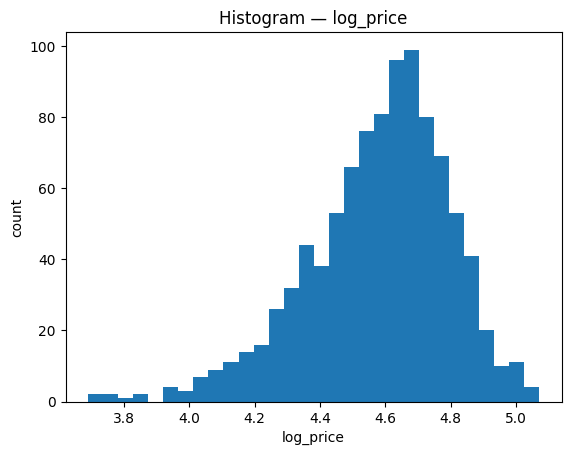

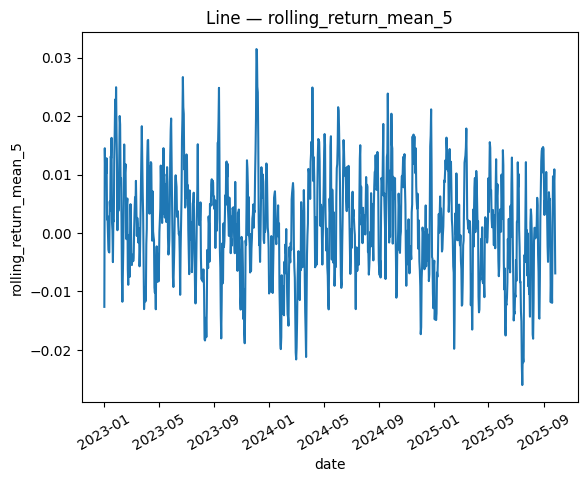

In [7]:
if 'log_price' in df.columns:
    plt.figure()
    plt.hist(df['log_price'].dropna(), bins=30)
    plt.title('Histogram — log_price')
    plt.xlabel('log_price')
    plt.ylabel('count')
    plt.show()
if 'rolling_return_mean_5' in df.columns and 'date' in df.columns:
    plt.figure()
    s = df[['date','rolling_return_mean_5']].dropna().sort_values('date')
    plt.plot(s['date'], s['rolling_return_mean_5'])
    plt.title('Line — rolling_return_mean_5')
    plt.xlabel('date')
    plt.ylabel('rolling_return_mean_5')
    plt.xticks(rotation=30)
    plt.show()

In [8]:
out = Path('data/processed')
out.mkdir(parents=True, exist_ok=True)
out_file = out / 'feature_engineered.csv'
df.to_csv(out_file, index=False)
out_file.as_posix()

'data/processed/feature_engineered.csv'